In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io

from pylab import rcParams
from tqdm import tqdm
from scipy import stats
from scipy.stats import zscore
from scipy.sparse import csr_matrix, hstack
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/listings.csv', low_memory=False)
print(f'There are {df.shape[0]} rows')
df.head(1)

There are 20677 rows


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190808195507,2019-08-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.12


## Categorical features

In [3]:
#Take a look at those that have either constant value or too many different values
desc = df.describe(include=[np.object]).T
desc[(desc['unique']==1)]

,count,unique,top,freq
experiences_offered,20677,1,none,20677
country_code,20677,1,NL,20677
country,20677,1,Netherlands,20677
has_availability,20677,1,t,20677
requires_license,20677,1,f,20677
is_business_travel_ready,20677,1,f,20677


All the accomodations are in Netherlands, each has_availability and doesn't require_license and is not business_travel_ready. So these features are not informative for us. <br>

In [4]:
#too many different values
desc[(desc['unique']>desc['count']*0.97)]

,count,unique,top,freq
listing_url,20677,20677,https://www.airbnb.com/rooms/13873040,1
name,20642,20167,Amsterdam,39
summary,20048,19472,Sleeping up to 2 guests in luxury surroundings...,40
space,15255,14843,This gorgeous apartment is excellently designe...,46
description,20458,20172,Hotel Jansen is a new Short Stay hotel in Amst...,13
picture_url,20677,20533,https://a0.muscache.com/im/pictures/af4cb1d9-2...,4


There are features with texts and urls. Texts are usefull, but need transformation, I'll do it later. Listing_urls are like IDs, I don't need it, picture_urls could be utilized as a source of visual information, but it need a specific research. I won't use this feature in this project. 

In [5]:
# too many empty values (more then 40%)
desc[(desc['count']<df.shape[0]*0.6)]

,count,unique,top,freq
notes,9154,7338,Freshly made up beds and crispy towels (one pe...,222
access,12209,9582,Guests are invited to enjoy the whole apartmen...,391
host_about,12077,9693,"Hi, I'm Martijn, \r\n\r\nWe are a team of prof...",208
host_response_time,12136,4,within an hour,6217
host_response_rate,12136,63,100%,9011
weekly_price,2591,333,$600.00,181
monthly_price,1408,296,"$2,000.00",96
license,25,7,GB 709304057,11


I believe that weekly_price and monthly_price could be usefull to calculate if it's a week or month discount that might be important for availability.

In [6]:
# All the rest categorical features
desc[(desc['unique']>1)&(desc['unique']<=desc['count']*0.97)&(desc['count']>=df.shape[0]*0.6)]

,count,unique,top,freq
last_scraped,20677,3,2019-08-09,13225
neighborhood_overview,14093,12780,Amsterdam West is one of the most diverse neig...,52
transit,14375,13636,You have not experienced the Dutch culture tru...,17
interaction,12689,10325,"Iamb&b will let you in, hand you the keys and ...",335
house_rules,12794,10754,House rules I kindly ask you to respect the f...,187
host_url,20677,17744,https://www.airbnb.com/users/show/65859990,208
host_name,20665,6083,Martijn,290
host_since,20665,3046,2016-04-05,212
host_location,20628,581,"Amsterdam, North Holland, Netherlands",10779
host_is_superhost,20665,2,f,17451


### Ideas for features transformations:

1) prices (price, weekly_price, monthly_price, security_deposit, cleaning_fee, extra_people) to numbers. Get rid of outliers. Calculate if it has weekly and monthly discounts <br> 
2) first_review, last_review, host_since to numbers (how long ago in days) <br>
3) amenities - spread the list to get each amenitie as separate feature<br>
4) map 1/0 dictionary to boolean features (host_is_superhost, host_has_profile_pic, host_identity_verified, is_location_exact, instant_bookable, require_guest_profile_picture, require_guest_phone_verification) <br>
5) Text features (name, summary, space, description, neighborhood_overview, notes, transit, access, interaction, house_rules) - to vectors (Bags of Words/Tfidf)<br>
6) OneHot Encode for: 'property_type', 'room_type', 'bed_type', 'cancellation_policy' <br>

I won't use some host features as I believe they are not informative. <br>
Geographical features will be considered later together with coordinates (latitude/longitude) 

Prices distribution skew =  1.95


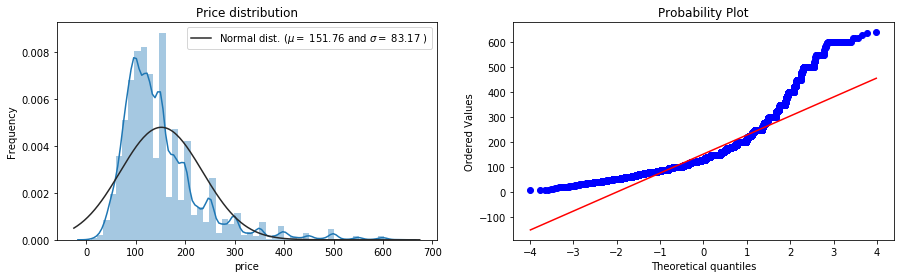

In [7]:
#1) prices (price, weekly_price, monthly_price, security_deposit, 
# cleaning_fee, extra_people) to numbers. Calculate weekly and monthly discounts
try:
    for col in ['price', 'weekly_price', 
                'monthly_price', 'security_deposit', 
                'cleaning_fee', 'extra_people']:
        df[col] = df[col].str.replace('[$,]','').astype(float)
    #outliers
    df = df[(zscore(df['price'])<3)&(df['price']>0)]
except:
    pass

prices_df = df[['price', 'weekly_price', 
            'monthly_price', 'security_deposit', 
            'cleaning_fee', 'extra_people']]
prices_df.at[:,'weekly_discount'] = prices_df.apply(lambda x: 1 if x['price']*7 > x['weekly_price']
                                               else 0, axis=1)
prices_df.at[:,'monthly_discount'] = prices_df.apply(lambda x: 1 if x['price']*30 > x['monthly_price']
                                               else 0, axis=1)

#explore price distribution
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(prices_df['price'], fit = norm, ax=ax1);
(mu, sigma) = norm.fit(prices_df['price'])
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax1.set_ylabel('Frequency')
ax1.title.set_text('Price distribution')
res = stats.probplot(prices_df['price'], plot=plt)
print('Prices distribution skew = ', round(prices_df['price'].skew(), 2))

The target feature price is a little bit right skewed. As linear models like normally distributed data, we will transform price and make it more normally distributed.

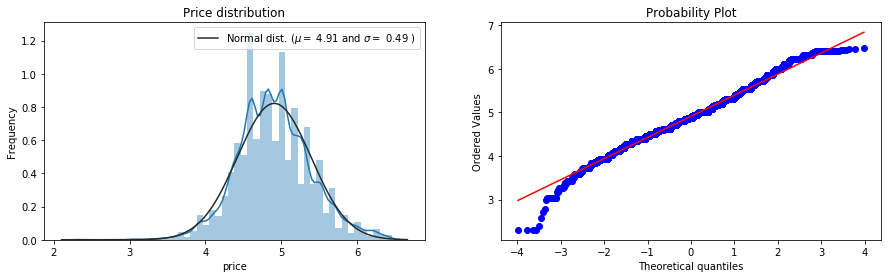

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
sns.distplot(np.log1p(prices_df['price']), fit = norm, ax=ax1);
(mu, sigma) = norm.fit(np.log1p(prices_df['price']))
ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax1.set_ylabel('Frequency')
ax1.title.set_text('Price distribution')
res = stats.probplot(np.log1p(prices_df['price']), plot=plt)

In [9]:
prices_df['log1p_price'] = np.log1p(prices_df['price'])

In [10]:
#2) first_review, last_review, host_since to numbers (how long ago in days). 
# If no reviews, fillna with negative value  
dates_df = pd.DataFrame()
dates_df['first_review'] = (pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['first_review'])).dt.days#.hist(bins=25)
dates_df[['first_review']] = dates_df[['first_review']].fillna(-1)
dates_df['last_review'] = (pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['last_review'])).dt.days
dates_df[['last_review']] = dates_df[['last_review']].fillna(-1)
dates_df['host_since'] = (pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['host_since'])).dt.days#.hist(bins=25)
dates_df[['host_since']] = dates_df[['host_since']].fillna(dates_df[['host_since']].mean())
dates_df.head()

,first_review,last_review,host_since
0,3784.0,4.0,3971.0
1,3447.0,14.0,3537.0
2,565.0,90.0,3549.0
3,2769.0,39.0,3426.0
4,3274.0,20.0,3375.0


In [11]:
#3) amenities - spread the list to get each amenitie as separate feature. the same with host_verifications + Aggregate rare amenities
amenities_df = df['amenities'].str.replace("[ \{\}\"]",'').str.get_dummies(sep=',')#.sum(axis=0).sort_values()#.apply(pd.Series)
am_desc = amenities_df.describe().T
other = amenities_df[am_desc[(am_desc['mean']<0.1)].index].sum(axis=1)
amenities_df = amenities_df[am_desc[(am_desc['mean']>=0.1)].index]
amenities_df['Other'] = other
amenities_df.columns

Index(['Bedlinens', 'Buzzer/wirelessintercom', 'CableTV',
       'Carbonmonoxidedetector', 'Coffeemaker', 'Cookingbasics',
       'Dishesandsilverware', 'Dishwasher', 'Dryer', 'Essentials',
       'Extrapillowsandblankets', 'Family/kidfriendly', 'Fireextinguisher',
       'Firstaidkit', 'Hairdryer', 'Hangers', 'Heating', 'Hostgreetsyou',
       'Hotwater', 'Internet', 'Iron', 'Kitchen', 'Laptopfriendlyworkspace',
       'Lockonbedroomdoor', 'Longtermstaysallowed', 'Luggagedropoffallowed',
       'Microwave', 'Oven', 'Paidparkingoffpremises', 'Patioorbalcony',
       'Privateentrance', 'Privatelivingroom', 'Refrigerator', 'Safetycard',
       'Shampoo', 'Smokedetector', 'Stove', 'TV', 'Washer', 'Wifi',
       'translationmissing:en.hosting_amenity_49',
       'translationmissing:en.hosting_amenity_50', 'Other'],
      dtype='object')

In [12]:
#4) map 1/0 dictionary to boolean features 
# (host_is_superhost, host_has_profile_pic, 
# host_identity_verified, is_location_exact, 
# instant_bookable, require_guest_profile_picture, require_guest_phone_verification) 
t_f_dict = {'t': 1, 'f': 0, 1: 1, 0: 0}
df['host_is_superhost'] = df['host_is_superhost'].map(t_f_dict)
df['host_has_profile_pic'] = df['host_has_profile_pic'].map(t_f_dict)
df['host_identity_verified'] = df['host_identity_verified'].map(t_f_dict)
df['is_location_exact'] = df['is_location_exact'].map(t_f_dict)
df['instant_bookable'] = df['instant_bookable'].map(t_f_dict)
df['require_guest_profile_picture'] = df['require_guest_profile_picture'].map(t_f_dict)
df['require_guest_phone_verification'] = df['require_guest_phone_verification'].map(t_f_dict)
binary_df = df[['host_is_superhost', 'host_has_profile_pic',
               'host_identity_verified', 'is_location_exact',
               'instant_bookable', 'require_guest_profile_picture',
               'require_guest_phone_verification']]
binary_df.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,1.0,1.0,0.0,0,1,0,0
1,0.0,1.0,0.0,1,0,0,0
2,0.0,1.0,0.0,0,0,0,0
3,1.0,1.0,1.0,1,1,0,0
4,1.0,1.0,1.0,1,0,0,0


In [13]:
#5) Texts transformation. I'll simply concatenate all text features, 
# lowercase them and get rid of symbols that are not letters
df[['listing_url', 
    'name', 
    'summary', 
    'space', 
    'description', 
    'neighborhood_overview', 
    'notes', 
    'transit', 
    'access', 
    'interaction', 
    'house_rules']] = df[['listing_url', 
    'name', 
    'summary', 
    'space', 
    'description', 
    'neighborhood_overview', 
    'notes', 
    'transit', 
    'access', 
    'interaction', 
    'house_rules']].fillna('')
df['desc'] = df['name'] + ' ' + df['summary'] + ' ' + df['space'] + ' ' + df['description'] \
 + ' ' + df['neighborhood_overview'] + ' ' + df['notes'] + ' ' + df['transit'] \
+ ' ' + df['access'] + ' ' + df['interaction'] + ' ' + df['house_rules']
df['desc'] = df['desc'].str.lower().str.replace('[\W]', ' ').str.replace('[ ]+', ' ')

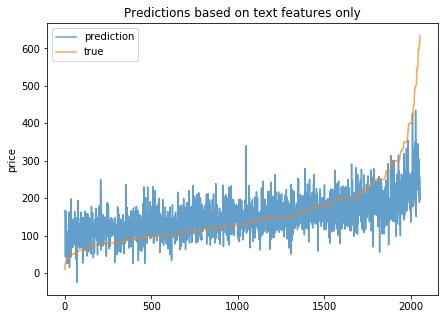

In [14]:
# Check if texts themselves can predict prices
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.5)
df[['desc']] = df[['desc']].fillna('')
df['desc'] = df['desc'].str.lower().str.replace('[\W]', ' ').str.replace('[ ]+', ' ')
X = df['desc']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
regression = Ridge().fit(X_train_vec, y_train)
pred = regression.predict(X_test_vec)
pred_df = pd.DataFrame({'prediction':pred})
pred_df['true'] = list(y_test)
rcParams['figure.figsize'] = 7, 5
pred_df.sort_values('true').reset_index()[['prediction', 'true']].plot(alpha=0.7);
plt.title('Predictions based on text features only')
plt.ylabel('price');

Although the predictions are quite inaccurate, but we can see a trend which follows the trend of ground truth.

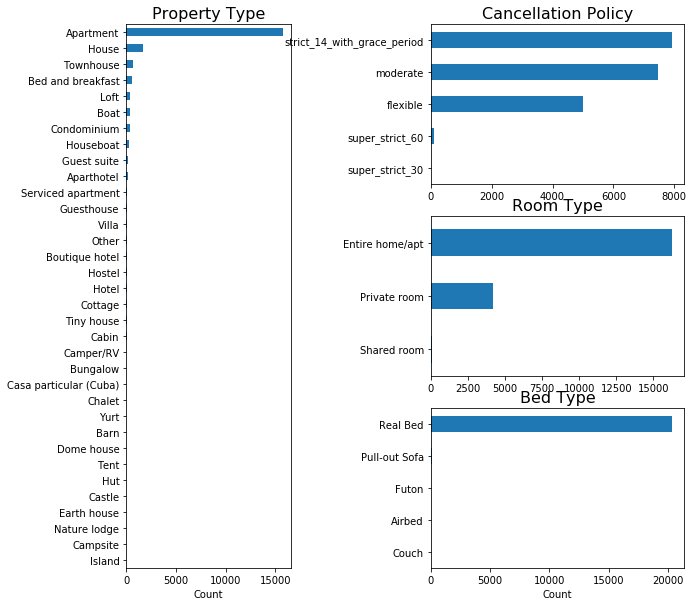

In [15]:
#6) OneHot Encode for: 'property_type', 'room_type', 'bed_type', 'cancellation_policy' 
fig = plt.figure(figsize=(10,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

ax1 = fig.add_subplot(131)
ax1 = df['property_type'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('Property Type', fontsize=16)
plt.xlabel('Count')
plt.ylabel("")

ax2 = fig.add_subplot(322)
ax2 = df['cancellation_policy'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('Cancellation Policy', fontsize=16)
# plt.xlabel('Count')
plt.ylabel("")

ax3 = fig.add_subplot(324)
ax3 = df['room_type'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('Room Type', fontsize=16)
# plt.xlabel('Count')
plt.ylabel("")

ax4 = fig.add_subplot(326)
ax4 = df['bed_type'].value_counts().sort_values(ascending=True).plot.barh()
plt.title('Bed Type', fontsize=16)
plt.xlabel('Count')
plt.ylabel("")

plt.tight_layout()
plt.show()

In [16]:
#Rare property types aggregate in "Others". Bed Type feature has too small diversity.
frequent_props = df.groupby('property_type').filter(lambda x: len(x)>df.shape[0]*0.01)['property_type'].unique()
df['new_property_type'] = df['property_type'].apply(lambda x: x if x in frequent_props
                                                    else 'Other_property_type')
df['cancellation_policy'].fillna(method='ffill', inplace=True)
properties_df = df[['new_property_type',
                    'cancellation_policy',
                    'room_type']]
# property_matrix = csr_matrix(hstack([OneHotEncoder().fit_transform(df[['new_property_type']]), 
#                           OneHotEncoder().fit_transform(df[['cancellation_policy']]),
#                           OneHotEncoder().fit_transform(df[['room_type']])]))

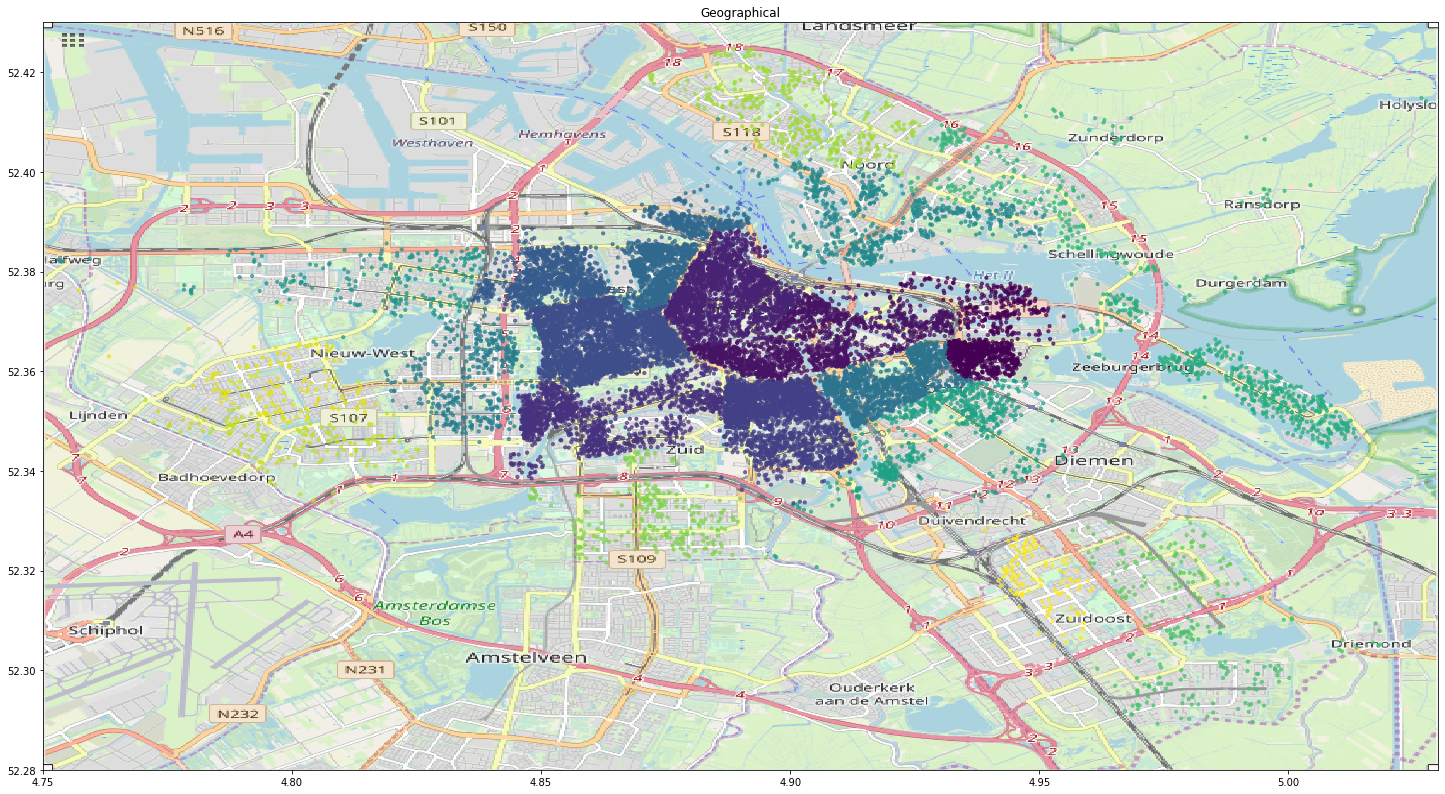

In [17]:
BBox = ((4.75, 5.03, 52.28, 52.43))
amster_pic = plt.imread('data/Amster_map.png')
rcParams['figure.figsize'] = 25, 25
fig, ax = plt.subplots()
ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.7, c=df.neighbourhood_cleansed.map({neig:i for i,neig in enumerate(df['neighbourhood_cleansed'].unique())}), s=10)
ax.set_title('Geographical')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(amster_pic, zorder=0, extent = BBox);

## Numeric Features

In [18]:
desc_nums = df.describe(include=[np.number]).T
# Too few nonempty values or id-columns
desc_nums[(desc_nums['count']<0.6*df.shape[0])|(desc_nums.index.str.contains('id'))]

,count,mean,std,min,25%,50%,75%,max
id,20533.0,1.788612e+07,1.041028e+07,2.818000e+03,9.324749e+06,1.769677e+07,2.596098e+07,3.759099e+07
scrape_id,20533.0,2.019081e+13,0.000000e+00,2.019081e+13,2.019081e+13,2.019081e+13,2.019081e+13,2.019081e+13
thumbnail_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xl_picture_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,20533.0,5.644143e+07,6.788344e+07,3.159000e+03,8.780994e+06,2.612731e+07,7.727211e+07,2.839422e+08
host_acceptance_rate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_identity_verified,20521.0,3.907217e-01,4.879240e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
square_feet,382.0,5.370445e+02,5.429623e+02,0.000000e+00,0.000000e+00,4.840000e+02,8.070000e+02,3.229000e+03


In [19]:
numeric_values = desc_nums[(desc_nums['count']>0.6*df.shape[0])&(~desc_nums.index.str.contains('id'))].index

Try PCA - for Linear Models

As we can see here all the accomodations are in Amsterdam. So we don't need the column "city". And the column "neighbourhood_cleansed" describes neighbourhoods accurately.

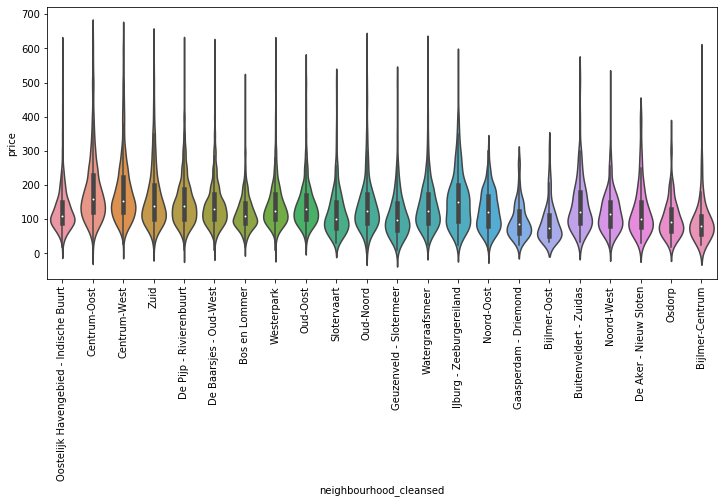

In [20]:
df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,5))
sns.violinplot(x="neighbourhood_cleansed", y="price", data=df, scale="width");
plt.xticks(rotation=90);

Some of price distributions are very similar. For example prices for Centrum-Oost and Centrum-West are likely to have one distribution. 

## Price prediction

In [27]:
X_train, X_test, y_train, y_test, y_price_train, y_price_test = train_test_split(pd.concat([df[['desc','neighbourhood_cleansed']], 
           binary_df, amenities_df, dates_df, properties_df, df[numeric_values]], axis=1).fillna(0), 
                                                    prices_df['log1p_price'], prices_df['price'],
                                                    test_size=0.1)

In [36]:
preprocess = ColumnTransformer(
    [('ohe_neighbourhood', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['neighbourhood_cleansed']),
     ('ohe_properties', OneHotEncoder(dtype='int', handle_unknown='ignore'), properties_df.columns),
     ('description_tfidf', TfidfVectorizer(stop_words = 'english', ngram_range=(1,2), max_df=0.5), 'desc'),
     ('scaler', StandardScaler(), list(numeric_values) + list(dates_df.columns) + ['Other']),
     ('scale_other_amenities', StandardScaler(), ['Other']),
     ('pssthrough', 'passthrough', list(binary_df.columns) + list(amenities_df.drop('Other', axis=1).columns))],
    remainder='drop')

In [ ]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

# model = make_pipeline(
#     preprocess,
#     XGBRegressor())#Ridge(solver = "lsqr", fit_intercept=False))
    
# model.fit(X_train, y_train)

# y_train_pred = model.predict(X_train)
# y_pred = model.predict(X_test)

# train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
# test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
# print('Train RMSE: %.4f' % train_rmse)
# print('Test RMSE: %.4f' % test_rmse)

In [46]:
model = make_pipeline(
    preprocess,
    Ridge(solver = "lsqr", fit_intercept=False))
    
model.fit(X_train, y_price_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_price_train))
test_rmse = np.sqrt(mean_squared_error(y_pred, y_price_test))
print('Train PRICE RMSE: %.4f' % train_rmse)
print('Test PRICE RMSE: %.4f' % test_rmse)

Train PRICE RMSE: 1.0310
Test PRICE RMSE: 1.2062


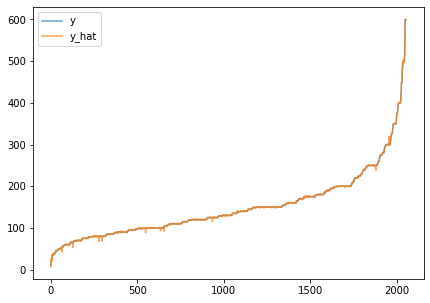

In [47]:
test_df = pd.DataFrame()
test_df['y'] = y_price_test
test_df['y_hat'] = y_pred
test_df = test_df.sort_values('y')

test_df.reset_index()[['y', 'y_hat']].plot(alpha=0.7)
plt.show()

In [55]:
model = make_pipeline(
    preprocess,
    RandomForestRegressor())
    
model.fit(X_train, y_price_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_price_train))
test_rmse = np.sqrt(mean_squared_error(y_pred, y_price_test))
print('Train PRICE RMSE: %.4f' % train_rmse)
print('Test PRICE RMSE: %.4f' % test_rmse)

Train PRICE RMSE: 0.1126
Test PRICE RMSE: 0.2529


In [ ]:
def ohe(train_colum, test_colum, alias, sparse=True):
    encoder = OneHotEncoder(sparse=sparse)
    if sparse:
        train = encoder.fit_transform(train_colum.values.reshape(-1, 1))
        test = encoder.transform(test_colum.values.reshape(-1, 1))
    else:   
        train = pd.DataFrame(encoder.fit_transform(train_colum.values.reshape(-1, 1)))
        train.columns = [f'{alias}_{i}' for i in train.columns]
        test = pd.DataFrame(encoder.transform(test_colum.values.reshape(-1, 1)))
        test.columns = [f'{alias}_{i}' for i in test.columns]
    return train, test

for feature in features_to_OHE:
    tr, te = ohe(train[feature], test[feature], feature)
    train_vects = csr_matrix(hstack([train_vects, tr]))
    test_vects = csr_matrix(hstack([test_vects, te]))
    
scaler = StandardScaler()
train_vects = csr_matrix(hstack([train_vects, scaler.fit_transform(train[features_to_scale])]))
test_vects = csr_matrix(hstack([test_vects, scaler.transform(test[features_to_scale])]))